In [1]:
# coding: utf-8
# 2018-04-12 copy of unet.ipynb

import os
import sys

from keras.models import Model, load_model
from keras.layers import Dense, Input, BatchNormalization, Dropout
from keras.layers import Add
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from keras import backend as K
from keras import optimizers
from keras import metrics
import datetime
import glob
import random
from pandas import DataFrame

import numpy as np
import matplotlib.pyplot as plt

class UNet_Experiment(object):
    '''
    UNet_Experiment is a test harness for running a variety of unet modifications quickly
    __init__: 
      version is looking for a string slug to be used in file names
      data_path is the string that will be passed to the glob function to grab files
      targ_path is the string that will be passed to the glob function to grab files
      UNET_ID is set to 0 by default, this indicates which unet will be used for this experiment
      RANDOMIZED is set to True by default, used for various testing
      VERBOSE is set to True by default, used for debugging, also used to decide whether images
        are printed to the screen
    '''
    
    #Recommended import: from unet import UNet_Experiment as ue
    #list of unet options
        
    def __init__(self, test_version, data_path, targ_path, EPOCHS = 0, RANDOMIZED = True, RAND_SEED = 17, VERBOSE = True):
        self.MODEL_NOTSET = -1
        self.MODEL_DEFAULT = 0
        self.MODEL_UNET0 = -99 #choose own parameters
        self.MODEL_UNET1 = 1
        self.MODEL_UNET2 = 2
        self.MODEL_UNET3 = 3
        self.MODEL_UNET4 = 4
        self.MODEL_UNET5 = 5
        self.MODEL_UNET6 = 6
        
        self.version = test_version
        self.randomized = RANDOMIZED
        self.unet_id = -1

        
        self.epochs = EPOCHS
        self.seed = RAND_SEED
        self.verbose = VERBOSE
        self.data_arr = grab_files_list(data_path, self.verbose)
        self.targ_arr = grab_files_list(targ_path, self.verbose)

        self.hist = None
        self.latest_model_fn = '' #TO IMPLEMENT
        
    def setup_data_bins(self, num_train, num_val, num_test=0, px=2048):
        num_tiles = len(self.data_arr)
        print(num_tiles)
        if((num_train + num_val + num_test) > num_tiles):
            print('Data bin distribution exceeds available tiles')
        else:
            tile_order_arr = self.get_tile_order(num_tiles)
            print(tile_order_arr)
            print(type(tile_order_arr))
            if (len(self.data_arr) == len(self.targ_arr)):
                #make training set
                self.train_dataset = []
                self.train_target = []
                for f in tile_order_arr[0:num_train]:  
                    loadIm(self.data_arr[f], self.targ_arr[f], self.train_dataset, self.train_target, px=px)
                    
                #changes values from [0,1] to [-1,1], convert to numpy array
                self.train_dataset = 2*np.array(self.train_dataset)-1 
                #convert to numpy array
                self.train_target = np.array(self.train_target)

                #debugging
                print('Tile #' + str(f))
                print(self.data_arr[f])  
                print(self.targ_arr[f])
                print(self.train_dataset.shape)
                print(self.train_target.shape)
                
                #make validation set
                self.val_dataset = []
                self.val_target = []
                for f in tile_order_arr[num_train:(num_train+num_val)]:    
                    loadIm(self.data_arr[f], self.targ_arr[f], self.val_dataset, self.val_target, px=px)
                                        
                #changes values from [0,1] to [-1,1], convert to numpy array
                self.val_dataset = 2*np.array(self.val_dataset)-1 
                #convert to numpy array
                self.val_target = np.array(self.val_target)

                #debugging
                print('Tile #' + str(f))
                print(self.data_arr[f])  
                print(self.targ_arr[f])
                print(self.val_dataset.shape)
                print(self.val_target.shape)

                #TODO: make test set
            
            else: 
                print('Lists of files for the filled and seg images were different sizes. ' + 
                      'No training and test bins created.')


    def set_model(self, UNET_ID):
        self.unet_id = UNET_ID
        if(self.unet_id is self.MODEL_DEFAULT):
            self.model = default_unet()
        elif(self.unet_id is self.MODEL_UNET1):
            self.model = unet1()
        elif(self.unet_id is self.MODEL_UNET2):
            self.model = unet2()
        elif(self.unet_id is self.MODEL_UNET3):
            self.model = unet3()
        elif(self.unet_id is self.MODEL_UNET4):
            self.model = unet4()
        elif(self.unet_id is self.MODEL_UNET5):
            self.model = unet5()
        elif(self.unet_id is self.MODEL_UNET6):
            self.model = unet6()
        elif(self.unet_id is self.MODEL_NOTSET):
            print("!! Model is not set !!")
        else:
            #add more options later
            print("UNET_ID: " + str(self.unet_id))
            self.model = default_unet()


    def compile_test_model(self):
        if (self.model is not None):
            adam = optimizers.Adam(lr=1e-4) #adam = updates, learning
            self.model.compile(adam, loss = 'binary_crossentropy', metrics=['acc']) #loss = log_loss or binary_crossentrophy
        else: 
            print("Model not compiled. No model assigned yet.")


    def train_model(self, addl_ep=500, ex=2, SAVE=True, PLOT=True):
        #epochs_at, dataset, target, testdata, testtarg are all taken from the global variables
        #calculates now for itself
        addl_hist = self.model.fit(self.train_dataset,self.train_target,batch_size = 10, epochs=addl_ep, validation_data=(self.val_dataset,self.val_target), shuffle=True)
        #history_addl = mod.fit(dataset,target,batch_size = 10, epochs=addl_ep, validation_data=(testdata,testtarg), shuffle=True)

        self.epochs = self.epochs + addl_ep
        print(self.epochs)

        now = datetime.datetime.now().strftime("%Y%m%d_%H%M")
        fn_ep = 'models/model_'+ self.version + '_epochs_' + str(self.epochs) + '_' + now + '.h5'
        if(SAVE):
            self.model.save(fn_ep)
        print(fn_ep + ', ' +  str(SAVE))
        
        #mod, ep_at, dataset, target, now, ver, data_type = 'Training', ex=4, SAVE = False
        show_progress(self.model, self.epochs, self.train_dataset, self.train_target, now, self.version, data_type = 'Training', ex = ex, SAVE=True)
        show_progress(self.model, self.epochs, self.val_dataset, self.val_target, now, self.version, data_type = 'Validation', ex = ex, SAVE=True)

        self.add_to_hist(addl_hist, now, PLOT=PLOT)
        return addl_hist
    
    def add_to_hist(self, addl_hist, now=None, PLOT=True):
        #self.hist = self.hist + addl_hist
#        self.hist['loss'] = self.hist['loss'] + addl_hist['loss']
        if(self.hist is None):
            self.hist = addl_hist
        else:
            for x in addl_hist.history.keys():
                self.hist.history[x] = self.hist.history[x] + addl_hist.history[x]
        if(PLOT):
            plot_hist(self.hist, self.version, self.epochs, NOW=now, SAVE=True, SHOW=True)

    def get_tile_order(self, num_tiles):
        rand_arr = list(range(num_tiles))

        if(self.randomized):
            random.seed(self.seed)
            random.shuffle(rand_arr)
        else:
            rand_arr
        return rand_arr
    
    
    def run_experiment(self, BINS = [1,1,0], MODEL_ID=0, init_ep=5, EX=2, SAVE=True, PX=2048):
        num_train, num_val, num_test = BINS
        self.setup_data_bins(num_train,num_val,num_test,px=PX)
        self.set_model(UNET_ID=MODEL_ID)
        self.compile_test_model()
        self.train_model(addl_ep=init_ep, ex=EX, SAVE=SAVE)
    
def plot_hist(hist_addl, VER, EP, NOW, SAVE=True, SHOW=True):
    if (NOW is None):
        NOW = datetime.datetime.now().strftime("%Y%m%d_%H%M")
    #plt.subplot(ex,3,3*i+1)
    #plt.title(data_type)
    #plt.imshow(-dataset[i,:,:,0])
    # plot train and validation loss across multiple runs
    plt.subplot(1,2,1)
    plt.plot(hist_addl.history['loss'], color='blue', label='train')
    plt.plot(hist_addl.history['val_loss'], color='orange', label='validation')
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val (test)'], loc='upper left')
    #plt.show()

    plt.subplot(1,2,2)
    # plot train and validation accuracy across multiple runs
    plt.plot(hist_addl.history['acc'], color='blue', label='train')
    plt.plot(hist_addl.history['val_acc'], color='orange', label='validation')
    plt.title('model train vs validation accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val (test)'], loc='upper left')

    plt.suptitle('UNet '+ VER + ' at ' + str(EP) + ' Epochs - ' + 'History')
    plt.gcf().set_size_inches((12,5))

    fn = 'plots/' + 'History' + '_model_'+ str(VER) + '_epochs_' + str(EP) +'_' + NOW + '.png'
    print(fn)
    plt.savefig(fn, bbox_inches='tight')
    plt.show()

#        Inputs: string path (regexp) that will cover a list of files or a single file
#                boolean verbose which toggles debugging print statements
#        
#        Return: arr
#        Purpose: pass in list of files that will be iterated over    
def grab_files_list(path, verbose):
    arr = glob.glob(path) #(glob.glob("Robbins_Dataset/synth_out/extracted_04-16km_on_blur2/*.png"))
    arr.sort()
    if (verbose):
        print(len(arr))
        print(arr)
    return arr

def loadIm(fname, tname, data, target, step=512, newpx = 512, px = 2048):    
    im = plt.imread(fname)
    #px = 2048 #im.size #TODO: FIX THIS IT WILL BREAK EVERYTHING
    print('max: ' + str(im.max()) + ', min: ' + str(im.min()) + ', mean: ' + str(im.mean()))
    tim = 1*(plt.imread(tname)>0) #makes values of target binary
    counter = 0
    print(im.shape)
    print(tim.shape)
    for y in range(0,px,step): #no need to sub 512 b/c px are mult of 512
        for x in range(0,px,step):
            data.append(im[x:x+newpx,y:y+newpx].reshape((newpx,newpx,1)))
            target.append(tim[x:x+newpx,y:y+newpx].reshape((newpx,newpx,1)))


# combine predDataset and predTestset as one that has a flag for training, validation, or test data set
def show_progress(mod, ep_at, dataset, target, now, ver, data_type = 'Training', ex=4, SAVE = True):    
    #Show progress on training data
    outs = mod.predict(dataset[0:ex]) #call predict on only what's needed
    
    for i in range(ex):
        plt.subplot(ex,3,3*i+1)
        plt.title(data_type)
        plt.imshow(-dataset[i,:,:,0])

        plt.subplot(ex,3,3*i+2)
        plt.title('Target')
        plt.imshow(target[i,:,:,0])

        plt.subplot(ex,3,3*i+3)
        plt.title('Prediction')
        plt.colorbar()
        plt.imshow(outs[i,:,:,0])

    plt.gcf().set_size_inches((12,ex*4))

    plt.suptitle('UNet '+ ver + ' at ' + str(ep_at) + ' Epochs - ' + data_type + ' Data Set')
    if(SAVE):
        fn = 'plots/' + data_type + '_model_'+ str(ver) + '_epochs_' + str(ep_at) +'_' + now + '.png'
        plt.savefig(fn, bbox_inches='tight')
    plt.show()


    
def default_unet(): 
    z1 = Input(shape=(512,512,1))
    print('z1: {}'.format(z1.shape))

    z2 = Conv2D(16, 3, padding='same', activation='relu')(z1)
    p2 = AveragePooling2D(pool_size=2)(z2)
    print('z2: {}, \np2: {}'.format(z2.shape, p2.shape))

    z3 = Conv2D(24, 3, padding='same', activation='relu')(p2)
    p3 = AveragePooling2D(pool_size=2)(z3)
    print('z3: {}, \np3: {}'.format(z3.shape, p3.shape))

    z4 = Conv2D(32, 3, padding='same', activation='relu')(p3)
    d4 = Dropout(0.2)(z4)
    p4 = AveragePooling2D(pool_size=2)(d4)
    print('z4: {}, \np4: {}'.format(z4.shape, p4.shape))

    z5 = Conv2D(48, 3, padding='same', activation='relu')(p4)
    d5 = Dropout(0.2)(z5)
    p5 = AveragePooling2D(pool_size=2)(d5)
    print('z5: {}'.format(z5.shape))

    z6 = Conv2D(64, 3, padding='same', activation='relu')(p5)
    d6 = Dropout(0.3)(z6)
    p6 = AveragePooling2D(pool_size=2)(d6)

    z7 = Conv2D(96, 3, padding='same', activation='relu')(p6)
    d7 = Dropout(0.4)(z7)
    p7 = AveragePooling2D(pool_size=2)(d7)

    z8 = Conv2D(128, 3, padding='same', activation='relu')(p7)
    d8 = Dropout(0.5)(z8)
    p8 = AveragePooling2D(pool_size=2)(d8)

    z9 = Conv2D(128, 3, padding='same', activation='relu')(p8)
    d9 = Dropout(0.5)(z9)

    u9 = UpSampling2D(size=2)(d9)
    q9 = Conv2D(128, 3, padding='same', activation='relu')(u9)
    d9b = Dropout(0.5)(q9)
    a9 = Add()([d9b,z8])

    u8 = UpSampling2D(size=2)(a9)
    q8 = Conv2D(96, 3, padding='same', activation='relu')(u8)
    d8b = Dropout(0.4)(q8)
    a8 = Add()([d8b,z7])

    u7 = UpSampling2D(size=2)(a8)
    q7 = Conv2D(64, 3, padding='same', activation='relu')(u7)
    d7b = Dropout(0.3)(q7)
    a7 = Add()([d7b,z6])

    u6 = UpSampling2D(size=2)(a7)
    q6 = Conv2D(48, 3, padding='same', activation='relu')(u6)
    d6b = Dropout(0.2)(q6)
    a6 = Add()([d6b,z5])

    u5 = UpSampling2D(size=2)(a6)
    q5 = Conv2D(32, 3, padding='same', activation='relu')(u5)
    d5b = Dropout(0.2)(q5)
    a5 = Add()([d5b,z4])

    u4 = UpSampling2D(size=2)(a5)
    q4 = Conv2D(24, 3, padding='same', activation='relu')(u4)
    a4 = Add()([q4,z3])

    u3 = UpSampling2D(size=2)(a4)
    q3 = Conv2D(16, 3, padding='same', activation='relu')(u3)
    a3 = Add()([q3,z2])

    z_final = Conv2D(1, 3, padding='same', activation='sigmoid')(a3)
    #z8 activation = sigmoid or softmax

    return Model(inputs = z1, outputs = z_final)

def unet1(): 
    ACT = 'relu'
    KERN_SIZE = 3
    FILTERS=[16,24,32,48,64,96,128,128]
    
    z1 = Input(shape=(None,None,1))
    print('z1: {}'.format(z1.shape))

    z2 = Conv2D(FILTERS[0], KERN_SIZE, padding='same', activation=ACT)(z1)
    p2 = AveragePooling2D(pool_size=2)(z2)
    print('z2: {}, \np2: {}'.format(z2.shape, p2.shape))

    z3 = Conv2D(FILTERS[1], KERN_SIZE, padding='same', activation=ACT)(p2)
    p3 = AveragePooling2D(pool_size=2)(z3)
    print('z3: {}, \np3: {}'.format(z3.shape, p3.shape))

    z4 = Conv2D(FILTERS[2], KERN_SIZE, padding='same', activation=ACT)(p3)
    d4 = Dropout(0.2)(z4)
    p4 = AveragePooling2D(pool_size=2)(d4)
    print('z4: {}, \np4: {}'.format(z4.shape, p4.shape))

    z5 = Conv2D(FILTERS[3], KERN_SIZE, padding='same', activation=ACT)(p4)
    d5 = Dropout(0.2)(z5)
    p5 = AveragePooling2D(pool_size=2)(d5)
    print('z5: {}'.format(z5.shape))

    z6 = Conv2D(FILTERS[4], KERN_SIZE, padding='same', activation=ACT)(p5)
    d6 = Dropout(0.3)(z6)
    p6 = AveragePooling2D(pool_size=2)(d6)

    z7 = Conv2D(FILTERS[5], KERN_SIZE, padding='same', activation=ACT)(p6)
    d7 = Dropout(0.4)(z7)
    p7 = AveragePooling2D(pool_size=2)(d7)

    z8 = Conv2D(FILTERS[6], KERN_SIZE, padding='same', activation=ACT)(p7)
    d8 = Dropout(0.5)(z8)
    p8 = AveragePooling2D(pool_size=2)(d8)

    z9 = Conv2D(FILTERS[7], KERN_SIZE, padding='same', activation=ACT)(p8)
    d9 = Dropout(0.5)(z9)

    u9 = UpSampling2D(size=2)(d9)
    q9 = Conv2D(FILTERS[6], KERN_SIZE, padding='same', activation=ACT)(u9)
    d9b = Dropout(0.5)(q9)
    a9 = Add()([d9b,z8])

    u8 = UpSampling2D(size=2)(a9)
    q8 = Conv2D(FILTERS[5], KERN_SIZE, padding='same', activation=ACT)(u8)
    d8b = Dropout(0.4)(q8)
    a8 = Add()([d8b,z7])

    u7 = UpSampling2D(size=2)(a8)
    q7 = Conv2D(FILTERS[4], KERN_SIZE, padding='same', activation=ACT)(u7)
    d7b = Dropout(0.3)(q7)
    a7 = Add()([d7b,z6])

    u6 = UpSampling2D(size=2)(a7)
    q6 = Conv2D(FILTERS[3], KERN_SIZE, padding='same', activation='relu')(u6)
    d6b = Dropout(0.2)(q6)
    a6 = Add()([d6b,z5])

    u5 = UpSampling2D(size=2)(a6)
    q5 = Conv2D(FILTERS[2], KERN_SIZE, padding='same', activation=ACT)(u5)
    d5b = Dropout(0.2)(q5)
    a5 = Add()([d5b,z4])

    u4 = UpSampling2D(size=2)(a5)
    q4 = Conv2D(FILTERS[1], KERN_SIZE, padding='same', activation=ACT)(u4)
    a4 = Add()([q4,z3])

    u3 = UpSampling2D(size=2)(a4)
    q3 = Conv2D(FILTERS[0], KERN_SIZE, padding='same', activation=ACT)(u3)
    a3 = Add()([q3,z2])

    z_final = Conv2D(1, KERN_SIZE, padding='same', activation='sigmoid')(a3)
    #z8 activation = sigmoid or softmax

    return Model(inputs = z1, outputs = z_final)

def unet2():
    ACT = 'relu'
    KERN_SIZE = 7
    FILTERS=[16,24,32,48,64,96,128,128]
    
    z1 = Input(shape=(None,None,1))
    print('z1: {}'.format(z1.shape))

    z2 = Conv2D(FILTERS[0], KERN_SIZE, padding='same', activation=ACT)(z1)
    p2 = AveragePooling2D(pool_size=2)(z2)
    print('z2: {}, \np2: {}'.format(z2.shape, p2.shape))

    z3 = Conv2D(FILTERS[1], KERN_SIZE, padding='same', activation=ACT)(p2)
    p3 = AveragePooling2D(pool_size=2)(z3)
    print('z3: {}, \np3: {}'.format(z3.shape, p3.shape))

    z4 = Conv2D(FILTERS[2], KERN_SIZE, padding='same', activation=ACT)(p3)
    d4 = Dropout(0.2)(z4)
    p4 = AveragePooling2D(pool_size=2)(d4)
    print('z4: {}, \np4: {}'.format(z4.shape, p4.shape))

    z5 = Conv2D(FILTERS[3], KERN_SIZE, padding='same', activation=ACT)(p4)
    d5 = Dropout(0.2)(z5)
    p5 = AveragePooling2D(pool_size=2)(d5)
    print('z5: {}'.format(z5.shape))

    z6 = Conv2D(FILTERS[4], KERN_SIZE, padding='same', activation=ACT)(p5)
    d6 = Dropout(0.3)(z6)
    p6 = AveragePooling2D(pool_size=2)(d6)

    z7 = Conv2D(FILTERS[5], KERN_SIZE, padding='same', activation=ACT)(p6)
    d7 = Dropout(0.4)(z7)
    p7 = AveragePooling2D(pool_size=2)(d7)

    z8 = Conv2D(FILTERS[6], KERN_SIZE, padding='same', activation=ACT)(p7)
    d8 = Dropout(0.5)(z8)
    p8 = AveragePooling2D(pool_size=2)(d8)

    z9 = Conv2D(FILTERS[7], KERN_SIZE, padding='same', activation=ACT)(p8)
    d9 = Dropout(0.5)(z9)

    u9 = UpSampling2D(size=2)(d9)
    q9 = Conv2D(FILTERS[6], KERN_SIZE, padding='same', activation=ACT)(u9)
    d9b = Dropout(0.5)(q9)
    a9 = Add()([d9b,z8])

    u8 = UpSampling2D(size=2)(a9)
    q8 = Conv2D(FILTERS[5], KERN_SIZE, padding='same', activation=ACT)(u8)
    d8b = Dropout(0.4)(q8)
    a8 = Add()([d8b,z7])

    u7 = UpSampling2D(size=2)(a8)
    q7 = Conv2D(FILTERS[4], KERN_SIZE, padding='same', activation=ACT)(u7)
    d7b = Dropout(0.3)(q7)
    a7 = Add()([d7b,z6])

    u6 = UpSampling2D(size=2)(a7)
    q6 = Conv2D(FILTERS[3], KERN_SIZE, padding='same', activation='relu')(u6)
    d6b = Dropout(0.2)(q6)
    a6 = Add()([d6b,z5])

    u5 = UpSampling2D(size=2)(a6)
    q5 = Conv2D(FILTERS[2], KERN_SIZE, padding='same', activation=ACT)(u5)
    d5b = Dropout(0.2)(q5)
    a5 = Add()([d5b,z4])

    u4 = UpSampling2D(size=2)(a5)
    q4 = Conv2D(FILTERS[1], KERN_SIZE, padding='same', activation=ACT)(u4)
    a4 = Add()([q4,z3])

    u3 = UpSampling2D(size=2)(a4)
    q3 = Conv2D(FILTERS[0], KERN_SIZE, padding='same', activation=ACT)(u3)
    a3 = Add()([q3,z2])

    z_final = Conv2D(1, KERN_SIZE, padding='same', activation='sigmoid')(a3)
    #z8 activation = sigmoid or softmax

    return Model(inputs = z1, outputs = z_final)


def unet3():
    ACT = 'relu'
    KERN_SIZE = 3
    #FILTERS=[128,128,128,128,128,128,128,128]
    #FILTERS=[16,24,32,48,64,96,128,128]
    #FILTERS = [i / 2 for i in FILTERS]
    FILTERS=[8,12,16,24,32,48,64,64]
    
    z1 = Input(shape=(None,None,1))
    print('z1: {}'.format(z1.shape))

    z2 = Conv2D(FILTERS[0], KERN_SIZE, padding='same', activation=ACT)(z1)
    p2 = AveragePooling2D(pool_size=2)(z2)
    print('z2: {}, \np2: {}'.format(z2.shape, p2.shape))

    z3 = Conv2D(FILTERS[1], KERN_SIZE, padding='same', activation=ACT)(p2)
    p3 = AveragePooling2D(pool_size=2)(z3)
    print('z3: {}, \np3: {}'.format(z3.shape, p3.shape))

    z4 = Conv2D(FILTERS[2], KERN_SIZE, padding='same', activation=ACT)(p3)
    d4 = Dropout(0.2)(z4)
    p4 = AveragePooling2D(pool_size=2)(d4)
    print('z4: {}, \np4: {}'.format(z4.shape, p4.shape))

    z5 = Conv2D(FILTERS[3], KERN_SIZE, padding='same', activation=ACT)(p4)
    d5 = Dropout(0.2)(z5)
    p5 = AveragePooling2D(pool_size=2)(d5)
    print('z5: {}'.format(z5.shape))

    z6 = Conv2D(FILTERS[4], KERN_SIZE, padding='same', activation=ACT)(p5)
    d6 = Dropout(0.3)(z6)
    p6 = AveragePooling2D(pool_size=2)(d6)

    z7 = Conv2D(FILTERS[5], KERN_SIZE, padding='same', activation=ACT)(p6)
    d7 = Dropout(0.4)(z7)
    p7 = AveragePooling2D(pool_size=2)(d7)

    z8 = Conv2D(FILTERS[6], KERN_SIZE, padding='same', activation=ACT)(p7)
    d8 = Dropout(0.5)(z8)
    p8 = AveragePooling2D(pool_size=2)(d8)

    z9 = Conv2D(FILTERS[7], KERN_SIZE, padding='same', activation=ACT)(p8)
    d9 = Dropout(0.5)(z9)

    u9 = UpSampling2D(size=2)(d9)
    q9 = Conv2D(FILTERS[6], KERN_SIZE, padding='same', activation=ACT)(u9)
    d9b = Dropout(0.5)(q9)
    a9 = Add()([d9b,z8])

    u8 = UpSampling2D(size=2)(a9)
    q8 = Conv2D(FILTERS[5], KERN_SIZE, padding='same', activation=ACT)(u8)
    d8b = Dropout(0.4)(q8)
    a8 = Add()([d8b,z7])

    u7 = UpSampling2D(size=2)(a8)
    q7 = Conv2D(FILTERS[4], KERN_SIZE, padding='same', activation=ACT)(u7)
    d7b = Dropout(0.3)(q7)
    a7 = Add()([d7b,z6])

    u6 = UpSampling2D(size=2)(a7)
    q6 = Conv2D(FILTERS[3], KERN_SIZE, padding='same', activation='relu')(u6)
    d6b = Dropout(0.2)(q6)
    a6 = Add()([d6b,z5])

    u5 = UpSampling2D(size=2)(a6)
    q5 = Conv2D(FILTERS[2], KERN_SIZE, padding='same', activation=ACT)(u5)
    d5b = Dropout(0.2)(q5)
    a5 = Add()([d5b,z4])

    u4 = UpSampling2D(size=2)(a5)
    q4 = Conv2D(FILTERS[1], KERN_SIZE, padding='same', activation=ACT)(u4)
    a4 = Add()([q4,z3])

    u3 = UpSampling2D(size=2)(a4)
    q3 = Conv2D(FILTERS[0], KERN_SIZE, padding='same', activation=ACT)(u3)
    a3 = Add()([q3,z2])

    z_final = Conv2D(1, KERN_SIZE, padding='same', activation='sigmoid')(a3)
    #z8 activation = sigmoid or softmax

    return Model(inputs = z1, outputs = z_final)

def unet4():
    ACT = 'relu'
    KERN_SIZE = 3
    FILTERS=[16,24,32,48,64,96,128,128]
    FILTERS = [i * 2 for i in FILTERS]
    
    
    z1 = Input(shape=(None,None,1))
    print('z1: {}'.format(z1.shape))

    z2 = Conv2D(FILTERS[0], KERN_SIZE, padding='same', activation=ACT)(z1)
    p2 = AveragePooling2D(pool_size=2)(z2)
    print('z2: {}, \np2: {}'.format(z2.shape, p2.shape))

    z3 = Conv2D(FILTERS[1], KERN_SIZE, padding='same', activation=ACT)(p2)
    p3 = AveragePooling2D(pool_size=2)(z3)
    print('z3: {}, \np3: {}'.format(z3.shape, p3.shape))

    z4 = Conv2D(FILTERS[2], KERN_SIZE, padding='same', activation=ACT)(p3)
    d4 = Dropout(0.2)(z4)
    p4 = AveragePooling2D(pool_size=2)(d4)
    print('z4: {}, \np4: {}'.format(z4.shape, p4.shape))

    z5 = Conv2D(FILTERS[3], KERN_SIZE, padding='same', activation=ACT)(p4)
    d5 = Dropout(0.2)(z5)
    p5 = AveragePooling2D(pool_size=2)(d5)
    print('z5: {}'.format(z5.shape))

    z6 = Conv2D(FILTERS[4], KERN_SIZE, padding='same', activation=ACT)(p5)
    d6 = Dropout(0.3)(z6)
    p6 = AveragePooling2D(pool_size=2)(d6)

    z7 = Conv2D(FILTERS[5], KERN_SIZE, padding='same', activation=ACT)(p6)
    d7 = Dropout(0.4)(z7)
    p7 = AveragePooling2D(pool_size=2)(d7)

    z8 = Conv2D(FILTERS[6], KERN_SIZE, padding='same', activation=ACT)(p7)
    d8 = Dropout(0.5)(z8)
    p8 = AveragePooling2D(pool_size=2)(d8)

    z9 = Conv2D(FILTERS[7], KERN_SIZE, padding='same', activation=ACT)(p8)
    d9 = Dropout(0.5)(z9)

    u9 = UpSampling2D(size=2)(d9)
    q9 = Conv2D(FILTERS[6], KERN_SIZE, padding='same', activation=ACT)(u9)
    d9b = Dropout(0.5)(q9)
    a9 = Add()([d9b,z8])

    u8 = UpSampling2D(size=2)(a9)
    q8 = Conv2D(FILTERS[5], KERN_SIZE, padding='same', activation=ACT)(u8)
    d8b = Dropout(0.4)(q8)
    a8 = Add()([d8b,z7])

    u7 = UpSampling2D(size=2)(a8)
    q7 = Conv2D(FILTERS[4], KERN_SIZE, padding='same', activation=ACT)(u7)
    d7b = Dropout(0.3)(q7)
    a7 = Add()([d7b,z6])

    u6 = UpSampling2D(size=2)(a7)
    q6 = Conv2D(FILTERS[3], KERN_SIZE, padding='same', activation='relu')(u6)
    d6b = Dropout(0.2)(q6)
    a6 = Add()([d6b,z5])

    u5 = UpSampling2D(size=2)(a6)
    q5 = Conv2D(FILTERS[2], KERN_SIZE, padding='same', activation=ACT)(u5)
    d5b = Dropout(0.2)(q5)
    a5 = Add()([d5b,z4])

    u4 = UpSampling2D(size=2)(a5)
    q4 = Conv2D(FILTERS[1], KERN_SIZE, padding='same', activation=ACT)(u4)
    a4 = Add()([q4,z3])

    u3 = UpSampling2D(size=2)(a4)
    q3 = Conv2D(FILTERS[0], KERN_SIZE, padding='same', activation=ACT)(u3)
    a3 = Add()([q3,z2])

    z_final = Conv2D(1, KERN_SIZE, padding='same', activation='sigmoid')(a3)
    #z8 activation = sigmoid or softmax

    return Model(inputs = z1, outputs = z_final)

def unet5():
    ACT = 'relu'
    KERN_SIZE = 11
    FILTERS=[16,24,32,48,64,96,128,128]
    #FILTERS = [i * 2 for i in FILTERS]
    #kern=7 and fil*4 --> resource exhausted
    #kern=3 and fil*4 --> resource exhausted
    #kern=3 and fil*3 --> resource exhausted
    
    z1 = Input(shape=(None,None,1))
    print('z1: {}'.format(z1.shape))

    z2 = Conv2D(FILTERS[0], KERN_SIZE, padding='same', activation=ACT)(z1)
    p2 = AveragePooling2D(pool_size=2)(z2)
    print('z2: {}, \np2: {}'.format(z2.shape, p2.shape))

    z3 = Conv2D(FILTERS[1], KERN_SIZE, padding='same', activation=ACT)(p2)
    p3 = AveragePooling2D(pool_size=2)(z3)
    print('z3: {}, \np3: {}'.format(z3.shape, p3.shape))

    z4 = Conv2D(FILTERS[2], KERN_SIZE, padding='same', activation=ACT)(p3)
    d4 = Dropout(0.2)(z4)
    p4 = AveragePooling2D(pool_size=2)(d4)
    print('z4: {}, \np4: {}'.format(z4.shape, p4.shape))

    z5 = Conv2D(FILTERS[3], KERN_SIZE, padding='same', activation=ACT)(p4)
    d5 = Dropout(0.2)(z5)
    p5 = AveragePooling2D(pool_size=2)(d5)
    print('z5: {}'.format(z5.shape))

    z6 = Conv2D(FILTERS[4], KERN_SIZE, padding='same', activation=ACT)(p5)
    d6 = Dropout(0.3)(z6)
    p6 = AveragePooling2D(pool_size=2)(d6)

    z7 = Conv2D(FILTERS[5], KERN_SIZE, padding='same', activation=ACT)(p6)
    d7 = Dropout(0.4)(z7)
    p7 = AveragePooling2D(pool_size=2)(d7)

    z8 = Conv2D(FILTERS[6], KERN_SIZE, padding='same', activation=ACT)(p7)
    d8 = Dropout(0.5)(z8)
    p8 = AveragePooling2D(pool_size=2)(d8)

    z9 = Conv2D(FILTERS[7], KERN_SIZE, padding='same', activation=ACT)(p8)
    d9 = Dropout(0.5)(z9)

    u9 = UpSampling2D(size=2)(d9)
    q9 = Conv2D(FILTERS[6], KERN_SIZE, padding='same', activation=ACT)(u9)
    d9b = Dropout(0.5)(q9)
    a9 = Add()([d9b,z8])

    u8 = UpSampling2D(size=2)(a9)
    q8 = Conv2D(FILTERS[5], KERN_SIZE, padding='same', activation=ACT)(u8)
    d8b = Dropout(0.4)(q8)
    a8 = Add()([d8b,z7])

    u7 = UpSampling2D(size=2)(a8)
    q7 = Conv2D(FILTERS[4], KERN_SIZE, padding='same', activation=ACT)(u7)
    d7b = Dropout(0.3)(q7)
    a7 = Add()([d7b,z6])

    u6 = UpSampling2D(size=2)(a7)
    q6 = Conv2D(FILTERS[3], KERN_SIZE, padding='same', activation='relu')(u6)
    d6b = Dropout(0.2)(q6)
    a6 = Add()([d6b,z5])

    u5 = UpSampling2D(size=2)(a6)
    q5 = Conv2D(FILTERS[2], KERN_SIZE, padding='same', activation=ACT)(u5)
    d5b = Dropout(0.2)(q5)
    a5 = Add()([d5b,z4])

    u4 = UpSampling2D(size=2)(a5)
    q4 = Conv2D(FILTERS[1], KERN_SIZE, padding='same', activation=ACT)(u4)
    a4 = Add()([q4,z3])

    u3 = UpSampling2D(size=2)(a4)
    q3 = Conv2D(FILTERS[0], KERN_SIZE, padding='same', activation=ACT)(u3)
    a3 = Add()([q3,z2])

    z_final = Conv2D(1, KERN_SIZE, padding='same', activation='sigmoid')(a3)
    #z8 activation = sigmoid or softmax

    return Model(inputs = z1, outputs = z_final)


def unet6():
    ACT = 'relu'
    KERN_SIZE = 7
    FILTERS=[16,24,32,48,64,96,128,128]
    FILTERS = [i * 2 for i in FILTERS]
    
    z1 = Input(shape=(None,None,1))
    print('z1: {}'.format(z1.shape))

    z2 = Conv2D(FILTERS[0], KERN_SIZE, padding='same', activation=ACT)(z1)
    p2 = AveragePooling2D(pool_size=2)(z2)
    print('z2: {}, \np2: {}'.format(z2.shape, p2.shape))

    z3 = Conv2D(FILTERS[1], KERN_SIZE, padding='same', activation=ACT)(p2)
    p3 = AveragePooling2D(pool_size=2)(z3)
    print('z3: {}, \np3: {}'.format(z3.shape, p3.shape))

    z4 = Conv2D(FILTERS[2], KERN_SIZE, padding='same', activation=ACT)(p3)
    d4 = Dropout(0.2)(z4)
    p4 = AveragePooling2D(pool_size=2)(d4)
    print('z4: {}, \np4: {}'.format(z4.shape, p4.shape))

    z5 = Conv2D(FILTERS[3], KERN_SIZE, padding='same', activation=ACT)(p4)
    d5 = Dropout(0.2)(z5)
    p5 = AveragePooling2D(pool_size=2)(d5)
    print('z5: {}'.format(z5.shape))

    z6 = Conv2D(FILTERS[4], KERN_SIZE, padding='same', activation=ACT)(p5)
    d6 = Dropout(0.3)(z6)
    p6 = AveragePooling2D(pool_size=2)(d6)

    z7 = Conv2D(FILTERS[5], KERN_SIZE, padding='same', activation=ACT)(p6)
    d7 = Dropout(0.4)(z7)
    p7 = AveragePooling2D(pool_size=2)(d7)

    z8 = Conv2D(FILTERS[6], KERN_SIZE, padding='same', activation=ACT)(p7)
    d8 = Dropout(0.5)(z8)
    p8 = AveragePooling2D(pool_size=2)(d8)

    z9 = Conv2D(FILTERS[7], KERN_SIZE, padding='same', activation=ACT)(p8)
    d9 = Dropout(0.5)(z9)

    u9 = UpSampling2D(size=2)(d9)
    q9 = Conv2D(FILTERS[6], KERN_SIZE, padding='same', activation=ACT)(u9)
    d9b = Dropout(0.5)(q9)
    a9 = Add()([d9b,z8])

    u8 = UpSampling2D(size=2)(a9)
    q8 = Conv2D(FILTERS[5], KERN_SIZE, padding='same', activation=ACT)(u8)
    d8b = Dropout(0.4)(q8)
    a8 = Add()([d8b,z7])

    u7 = UpSampling2D(size=2)(a8)
    q7 = Conv2D(FILTERS[4], KERN_SIZE, padding='same', activation=ACT)(u7)
    d7b = Dropout(0.3)(q7)
    a7 = Add()([d7b,z6])

    u6 = UpSampling2D(size=2)(a7)
    q6 = Conv2D(FILTERS[3], KERN_SIZE, padding='same', activation='relu')(u6)
    d6b = Dropout(0.2)(q6)
    a6 = Add()([d6b,z5])

    u5 = UpSampling2D(size=2)(a6)
    q5 = Conv2D(FILTERS[2], KERN_SIZE, padding='same', activation=ACT)(u5)
    d5b = Dropout(0.2)(q5)
    a5 = Add()([d5b,z4])

    u4 = UpSampling2D(size=2)(a5)
    q4 = Conv2D(FILTERS[1], KERN_SIZE, padding='same', activation=ACT)(u4)
    a4 = Add()([q4,z3])

    u3 = UpSampling2D(size=2)(a4)
    q3 = Conv2D(FILTERS[0], KERN_SIZE, padding='same', activation=ACT)(u3)
    a3 = Add()([q3,z2])

    z_final = Conv2D(1, KERN_SIZE, padding='same', activation='sigmoid')(a3)
    #z8 activation = sigmoid or softmax

    return Model(inputs = z1, outputs = z_final)


def unet0(KERN_SIZE=3, ACT='relu', FILTERS=[16,24,32,48,64,96,128,128]):
    #ACT = 'relu'
    #KERN_SIZE = 3
    #FILTERS=[16,24,32,48,64,96,128,128]
    
    z1 = Input(shape=(None,None,1))
    print('z1: {}'.format(z1.shape))

    z2 = Conv2D(FILTERS[0], KERN_SIZE, padding='same', activation=ACT)(z1)
    p2 = AveragePooling2D(pool_size=2)(z2)
    print('z2: {}, \np2: {}'.format(z2.shape, p2.shape))

    z3 = Conv2D(FILTERS[1], KERN_SIZE, padding='same', activation=ACT)(p2)
    p3 = AveragePooling2D(pool_size=2)(z3)
    print('z3: {}, \np3: {}'.format(z3.shape, p3.shape))

    z4 = Conv2D(FILTERS[2], KERN_SIZE, padding='same', activation=ACT)(p3)
    d4 = Dropout(0.2)(z4)
    p4 = AveragePooling2D(pool_size=2)(d4)
    print('z4: {}, \np4: {}'.format(z4.shape, p4.shape))

    z5 = Conv2D(FILTERS[3], KERN_SIZE, padding='same', activation=ACT)(p4)
    d5 = Dropout(0.2)(z5)
    p5 = AveragePooling2D(pool_size=2)(d5)
    print('z5: {}'.format(z5.shape))

    z6 = Conv2D(FILTERS[4], KERN_SIZE, padding='same', activation=ACT)(p5)
    d6 = Dropout(0.3)(z6)
    p6 = AveragePooling2D(pool_size=2)(d6)

    z7 = Conv2D(FILTERS[5], KERN_SIZE, padding='same', activation=ACT)(p6)
    d7 = Dropout(0.4)(z7)
    p7 = AveragePooling2D(pool_size=2)(d7)

    z8 = Conv2D(FILTERS[6], KERN_SIZE, padding='same', activation=ACT)(p7)
    d8 = Dropout(0.5)(z8)
    p8 = AveragePooling2D(pool_size=2)(d8)

    z9 = Conv2D(FILTERS[7], KERN_SIZE, padding='same', activation=ACT)(p8)
    d9 = Dropout(0.5)(z9)

    u9 = UpSampling2D(size=2)(d9)
    q9 = Conv2D(FILTERS[6], KERN_SIZE, padding='same', activation=ACT)(u9)
    d9b = Dropout(0.5)(q9)
    a9 = Add()([d9b,z8])

    u8 = UpSampling2D(size=2)(a9)
    q8 = Conv2D(FILTERS[5], KERN_SIZE, padding='same', activation=ACT)(u8)
    d8b = Dropout(0.4)(q8)
    a8 = Add()([d8b,z7])

    u7 = UpSampling2D(size=2)(a8)
    q7 = Conv2D(FILTERS[4], KERN_SIZE, padding='same', activation=ACT)(u7)
    d7b = Dropout(0.3)(q7)
    a7 = Add()([d7b,z6])

    u6 = UpSampling2D(size=2)(a7)
    q6 = Conv2D(FILTERS[3], KERN_SIZE, padding='same', activation='relu')(u6)
    d6b = Dropout(0.2)(q6)
    a6 = Add()([d6b,z5])

    u5 = UpSampling2D(size=2)(a6)
    q5 = Conv2D(FILTERS[2], KERN_SIZE, padding='same', activation=ACT)(u5)
    d5b = Dropout(0.2)(q5)
    a5 = Add()([d5b,z4])

    u4 = UpSampling2D(size=2)(a5)
    q4 = Conv2D(FILTERS[1], KERN_SIZE, padding='same', activation=ACT)(u4)
    a4 = Add()([q4,z3])

    u3 = UpSampling2D(size=2)(a4)
    q3 = Conv2D(FILTERS[0], KERN_SIZE, padding='same', activation=ACT)(u3)
    a3 = Add()([q3,z2])

    z_final = Conv2D(1, KERN_SIZE, padding='same', activation='sigmoid')(a3)
    #z8 activation = sigmoid or softmax

    return Model(inputs = z1, outputs = z_final)

In [2]:
expt=UNet_Experiment("expt","C:/Users/mejri/Downloads/CraterSegCNN-master (1)/CraterSegCNN-master/Robbins_Dataset/out/data/*.png", "C:/Users/mejri/Downloads/CraterSegCNN-master (1)/CraterSegCNN-master/Robbins_Dataset/out/label/*.png", EPOCHS = 0, RANDOMIZED = True, RAND_SEED = 17, VERBOSE = True)

24
['C:/Users/mejri/Downloads/CraterSegCNN-master (1)/CraterSegCNN-master/Robbins_Dataset/out/data\\thm_dir_N-30_000_-30_0_0_30_filled.png', 'C:/Users/mejri/Downloads/CraterSegCNN-master (1)/CraterSegCNN-master/Robbins_Dataset/out/data\\thm_dir_N-30_030_-30_0_30_60_filled.png', 'C:/Users/mejri/Downloads/CraterSegCNN-master (1)/CraterSegCNN-master/Robbins_Dataset/out/data\\thm_dir_N-30_060_-30_0_60_90_filled.png', 'C:/Users/mejri/Downloads/CraterSegCNN-master (1)/CraterSegCNN-master/Robbins_Dataset/out/data\\thm_dir_N-30_090_-30_0_90_120_filled.png', 'C:/Users/mejri/Downloads/CraterSegCNN-master (1)/CraterSegCNN-master/Robbins_Dataset/out/data\\thm_dir_N-30_120_-30_0_120_150_filled.png', 'C:/Users/mejri/Downloads/CraterSegCNN-master (1)/CraterSegCNN-master/Robbins_Dataset/out/data\\thm_dir_N-30_150_-30_0_150_180_filled.png', 'C:/Users/mejri/Downloads/CraterSegCNN-master (1)/CraterSegCNN-master/Robbins_Dataset/out/data\\thm_dir_N-30_180_-30_0_-180_-150_filled.png', 'C:/Users/mejri/Downlo

In [3]:
expt.setup_data_bins(19, 2, num_test=1, px=2048)

24
[19, 22, 2, 1, 12, 10, 7, 18, 23, 4, 20, 6, 15, 0, 14, 3, 8, 17, 5, 21, 11, 9, 13, 16]
<class 'list'>
max: 1.0, min: 0.003921569, mean: 0.49112135
(7680, 7680)
(7680, 7680)
max: 1.0, min: 0.003921569, mean: 0.48980218
(7680, 7680)
(7680, 7680)
max: 1.0, min: 0.003921569, mean: 0.49546736
(7680, 7680)
(7680, 7680)
max: 1.0, min: 0.003921569, mean: 0.49514303
(7680, 7680)
(7680, 7680)
max: 1.0, min: 0.003921569, mean: 0.48936468
(7680, 7680)
(7680, 7680)
max: 1.0, min: 0.003921569, mean: 0.4936926
(7680, 7680)
(7680, 7680)
max: 1.0, min: 0.003921569, mean: 0.49139324
(7680, 7680)
(7680, 7680)
max: 1.0, min: 0.003921569, mean: 0.49216554
(7680, 7680)
(7680, 7680)
max: 1.0, min: 0.003921569, mean: 0.49044687
(7680, 7680)
(7680, 7680)
max: 1.0, min: 0.003921569, mean: 0.49317557
(7680, 7680)
(7680, 7680)
max: 1.0, min: 0.003921569, mean: 0.48968545
(7680, 7680)
(7680, 7680)
max: 1.0, min: 0.003921569, mean: 0.49279016
(7680, 7680)
(7680, 7680)
max: 1.0, min: 0.003921569, mean: 0.49021074

In [4]:
expt.set_model(0)

z1: (None, 512, 512, 1)
z2: (None, 512, 512, 16), 
p2: (None, 256, 256, 16)
z3: (None, 256, 256, 24), 
p3: (None, 128, 128, 24)
z4: (None, 128, 128, 32), 
p4: (None, 64, 64, 32)
z5: (None, 64, 64, 48)


In [5]:
expt.compile_test_model()

C:\Users\mejri\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/5
31/31 [==============================] - 80s 3s/step - loss: 0.5476 - acc: 0.8346 - val_loss: 0.3671 - val_acc: 0.9141
Epoch 2/5
31/31 [==============================] - 82s 3s/step - loss: 0.3644 - acc: 0.9100 - val_loss: 0.3469 - val_acc: 0.9144
Epoch 3/5
31/31 [==============================] - 79s 3s/step - loss: 0.3413 - acc: 0.9102 - val_loss: 0.3133 - val_acc: 0.9145
Epoch 4/5
31/31 [==============================] - 79s 3s/step - loss: 0.3226 - acc: 0.9103 - val_loss: 0.3037 - val_acc: 0.9146
Epoch 5/5
31/31 [==============================] - 80s 3s/step - loss: 0.3082 - acc: 0.9104 - val_loss: 0.2791 - val_acc: 0.9146
5
models/model_expt_epochs_5_20221216_2250.h5, True
1/1 [==============================] - 0s 490ms/step


C:\Users\mejri\AppData\Local\Temp\ipykernel_4108\823118576.py:275: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar()


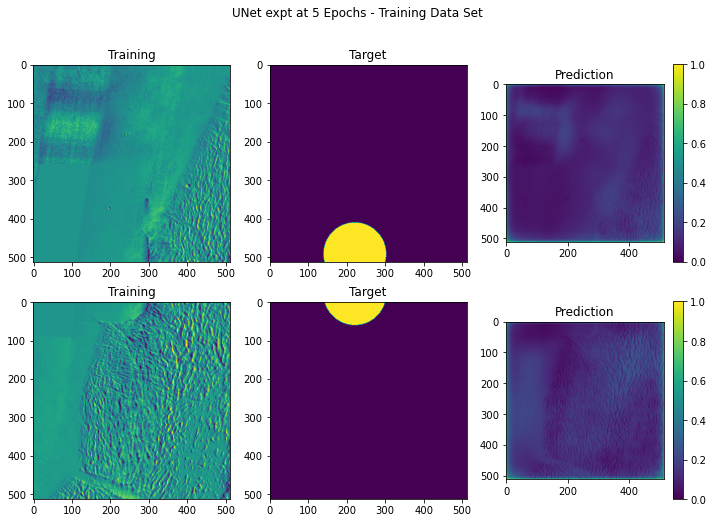

1/1 [==============================] - 0s 102ms/step


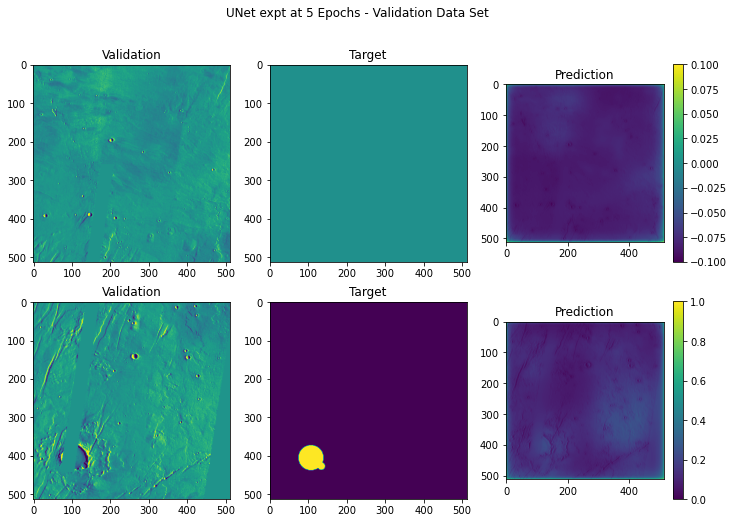

plots/History_model_expt_epochs_5_20221216_2250.png


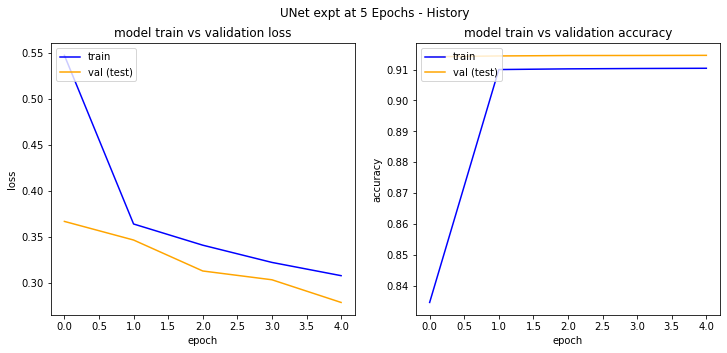

In [6]:
hist=expt.train_model(addl_ep=5, ex=2, SAVE=True, PLOT=True)

plots/History_model_expt_epochs_5_20221216_2252.png


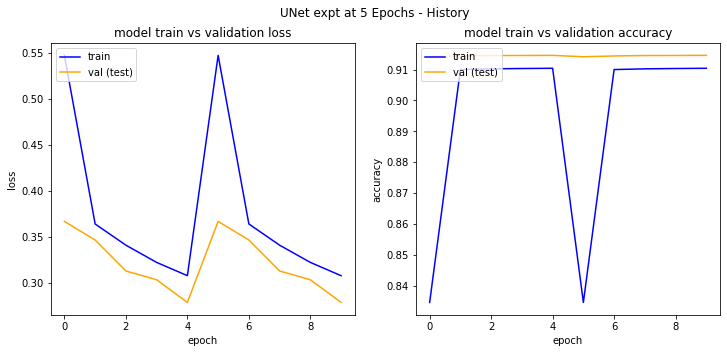

In [8]:
expt.add_to_hist(hist, now=None, PLOT=True)

In [9]:
expt.get_tile_order(24)

[19,
 22,
 2,
 1,
 12,
 10,
 7,
 18,
 23,
 4,
 20,
 6,
 15,
 0,
 14,
 3,
 8,
 17,
 5,
 21,
 11,
 9,
 13,
 16]

24
[19, 22, 2, 1, 12, 10, 7, 18, 23, 4, 20, 6, 15, 0, 14, 3, 8, 17, 5, 21, 11, 9, 13, 16]
<class 'list'>
max: 1.0, min: 0.003921569, mean: 0.49112135
(7680, 7680)
(7680, 7680)
Tile #19
C:/Users/mejri/Downloads/CraterSegCNN-master (1)/CraterSegCNN-master/Robbins_Dataset/out/data\thm_dir_N00_210_0_30_-150_-120_filled.png
C:/Users/mejri/Downloads/CraterSegCNN-master (1)/CraterSegCNN-master/Robbins_Dataset/out/label\thm_dir_N00_210_0_30_-150_-120_2_32_km_segrng.png
(16, 512, 512, 1)
(16, 512, 512, 1)
max: 1.0, min: 0.003921569, mean: 0.48980218
(7680, 7680)
(7680, 7680)
Tile #22
C:/Users/mejri/Downloads/CraterSegCNN-master (1)/CraterSegCNN-master/Robbins_Dataset/out/data\thm_dir_N00_300_0_30_-60_-30_filled.png
C:/Users/mejri/Downloads/CraterSegCNN-master (1)/CraterSegCNN-master/Robbins_Dataset/out/label\thm_dir_N00_300_0_30_-60_-30_2_32_km_segrng.png
(16, 512, 512, 1)
(16, 512, 512, 1)
z1: (None, 512, 512, 1)
z2: (None, 512, 512, 16), 
p2: (None, 256, 256, 16)
z3: (None, 256, 256, 24), 
p3

C:\Users\mejri\AppData\Local\Temp\ipykernel_4108\823118576.py:275: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar()


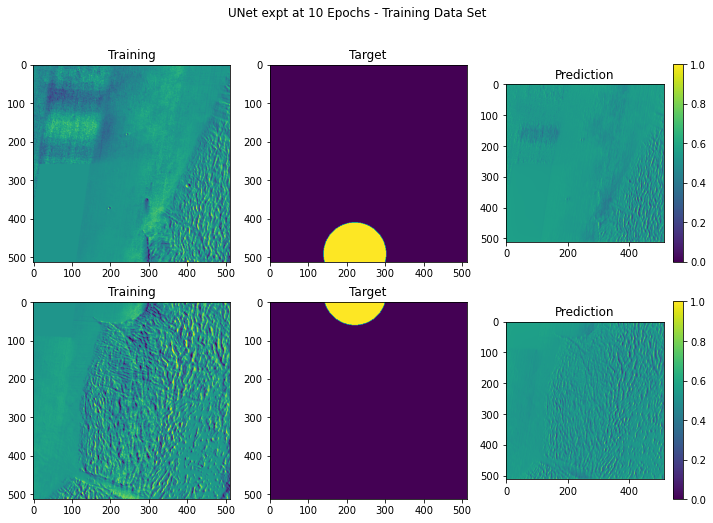

1/1 [==============================] - 0s 109ms/step


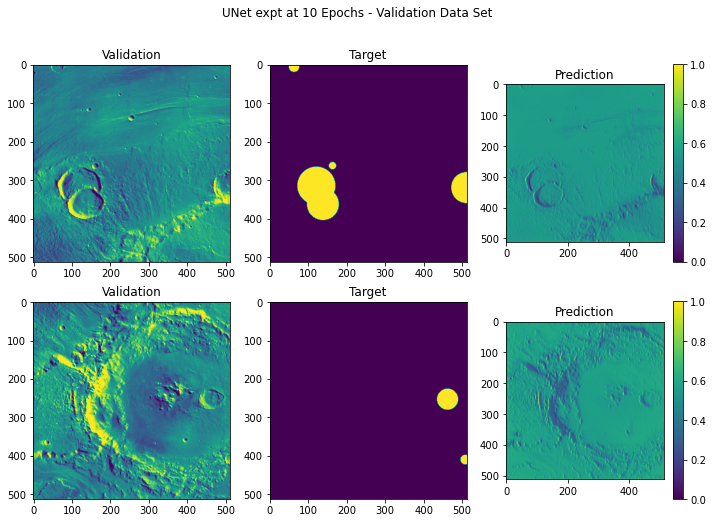

plots/History_model_expt_epochs_10_20221216_2254.png


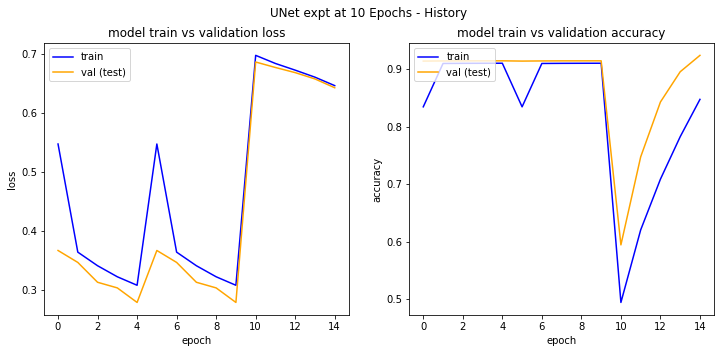

In [10]:
expt.run_experiment(BINS = [1,1,0], MODEL_ID=0, init_ep=5, EX=2, SAVE=True, PX=2048)

In [11]:
# coding: utf-8

#all template match code adapted from the DeepMoon project
#https://github.com/silburt/DeepMoon/blob/master/utils/template_match_target.py

import numpy as np
from skimage.feature import match_template
import cv2
import os
import sys
from keras.models import Model, load_model
#from keras.layers import Dense, Input, BatchNormalization, Dropout
#from keras.layers.merge import Add
#from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
#from keras import backend as K
#from keras import optimizers
#from keras import metrics
import datetime
import glob
import random
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging

class Match_Tiles(object):
    '''
    Match_Tiles is a test harness for running a variety of matching modifications quickly
    __init__: 
      version is looking for a string slug for the model, to be used in file names
      data_path is the string that will be passed to the glob function to grab files
      targ_path is the string that will be passed to the glob function to grab files
      VERBOSE is set to True by default, used for debugging, also used to decide whether images
        are printed to the screen
    '''
    
    #Recommended import: from match_utils import Match_Tiles as mt
    
        
    """
    Tuned Crater Detection Hyperparameters
    --------------------------------------
    minrad, maxrad : ints
        radius range in match_template to search over.
    longlat_thresh2, rad_thresh : floats
        if ((x1-x2)^2 + (y1-y2)^2) / min(r1,r2)^2 < longlat_thresh2 and
        abs(r1-r2) / min(r1,r2) < rad_thresh, remove (x2,y2,r2) circle (it is
        a duplicate of another crater candidate). In addition, when matching
        CNN-detected rings to corresponding csvs (i.e. template_match_t2c),
        the same criteria is used to determine a match.
    template_thresh : float
        0-1 range. If match_template probability > template_thresh, count as 
        detection.
    target_thresh : float
        0-1 range. target[target > target_thresh] = 1, otherwise 0
    rw : int
        1-32 range. Ring width, thickness of the rings used to match craters.
    """

    longlat_thresh2_ = 1.8
    rad_thresh_ = 1.0
    template_thresh_ = 0.5
    minrad_ = 6
    maxrad_ = 140
    target_thresh_ = 0.1
    rw_ = 8
        
    def __init__(self, model_version, model_path, data_path, targ_path, csv_path, rw=8, minrpx=7, maxrpx=140, tt=0.4,
                 RANDOMIZED=True, VERBOSE=True, log_str=''):        

        #Defaults tuned by DeepMoon team, all have '_' after
        self.longlat_thresh2_ = 1.8
        self.rad_thresh_ = 1.0
        self.template_thresh_ = 0.5
        self.minrad_ = 6
        self.maxrad_ = 140
        self.target_thresh_ = 0.1
        self.rw_ = 8

        #string name of model version, used for saving
        self.version = model_version
        
        self.verbose = VERBOSE
        #load files from paths
        self.data_arr = grab_files_list(data_path, self.verbose)
        self.targ_arr = grab_files_list(targ_path, self.verbose)
        self.csv_hu_arr = grab_files_list(csv_path, self.verbose)
        
        #load model
        self.model = load_model(model_path)
        
        #crater coord params
        self.coords_arr = None
        self.rw = rw #8 or 4
        self.minr_px = minrpx #6 #2km = 8.6 px
        self.maxr_px = maxrpx #140 #32 km = 138.2 px
        self.targ_thresh = tt
        
        #set up logging capabilities
        #docs: https://docs.python.org/2.3/lib/node304.html
        logger_name = 'test_log' + get_time()
        self.logger = logging.getLogger(logger_name)
        hdlr = logging.FileHandler('log/match_test_log_'+str(model_version)+'_'+get_time()+'.log')
        formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
        hdlr.setFormatter(formatter)
        self.logger.addHandler(hdlr) 
        self.logger.setLevel(logging.INFO)
        self.logger.info('New log file created for this test: '+ model_version)
        #report the model_path, data_path, targ_path, & csv_path
        self.logger.info('Model path: '+ model_path)
        self.logger.info('Data path: '+ data_path)
        self.logger.info('Target path: '+ targ_path)
        self.logger.info('CSV path: '+ csv_path)
        
#    def run_match_all_tiles(self):
#        #load files from paths
#        #loop over number of tiles
#        #check they are valid 
#        return None
    
    
    def run_match_one_tile(self, data_fn, targ_fn, csv_px_fn): #move this out of self-land        
        data = []
        target = []

        loadIm(data_fn, targ_fn, data, target, step=512, newpx = 512, px = 7680)

        data = 2*np.array(data)-1
        target = np.array(target)

        print(data.shape)

        # Load model
        #fn_model = 'models/model_v13d_epochs_500_20180510_0458.h5'# d_epochs_500_20180508_0343.h5' #selected arbitrarily, v13a didn't work?
        #mod = load_model(fn_model)
        mod = self.model
        print('Model loaded at: ' + get_time())
        self.logger.info('Model loaded at: ' + get_time())

        # Run model on one tile's worth of data
        outs = mod.predict(data)
        print('Prediction finished at: ' + get_time())
        self.logger.info('Prediction finished at: ' + get_time())
            
        #Make the model output back into a tile
        tile_pred = remake_tile(outs, tile_size=7680, SHOW=False)
        
        #Make the orig data & target back into a tile (this should match the input target)
        tile_data = remake_tile(data, tile_size=7680, SHOW=False)
        tile_targ = remake_tile(target, tile_size=7680, SHOW=False)
        print('Tiles put back together at: ' + get_time())
        self.logger.info('Tiles put back together at: ' + get_time())
        
        #make copy of tile_pred *because the template match changes the np array directly
        copy_tile_pred = np.copy(tile_pred)
        
        #call crater_match
        tile_crater_coords = self.template_match_t(copy_tile_pred, minrad=self.minr_px, maxrad=self.maxr_px,
                 longlat_thresh2=self.longlat_thresh2_, rad_thresh=self.rad_thresh_,
                 template_thresh=self.template_thresh_,
                 target_thresh=self.targ_thresh, rw=self.rw)
        print('Coordinates determined from prediction at: ' + get_time())
        self.logger.info('Coordinates determined from prediction at: ' + get_time())
        
        #make image showing comparison 
        #crater_list_to_image(crater_array, img_size=2048)
        tile_found = crater_list_to_image(tile_crater_coords, img_size=7680)
        print('Crater list in new image finished at: ' + get_time())
        self.logger.info('Crater list in new image finished at: ' + get_time())
        
        #four_image(data_image, targ_image, pred_image, find_image, start_x=0, start_y=0, wid_ht=1024)
        four_image(tile_data, tile_targ, tile_pred, tile_found, start_x=0, start_y=0, wid_ht=1024)
        
        return tile_pred, tile_crater_coords 
    
    def run_compare_one_tile(self, csv_px_fn, tile_pred, list_coords=None):      
        csv_px_xyr = make_csv_px_array(csv_px_fn)
        csv_coords = np.copy(csv_px_xyr)
        
        copy_tile_pred = np.copy(tile_pred)
        #\
        stats, err, frac_dupes, templ_coords = self.template_match_t2c(copy_tile_pred, 
                    csv_coords, templ_coords=list_coords, 
                    minrad=self.minr_px, maxrad=self.maxr_px, 
                    longlat_thresh2=self.longlat_thresh2_, rad_thresh=self.rad_thresh_, 
                    template_thresh=self.template_thresh_, target_thresh=self.targ_thresh, 
                    rw=self.rw, rmv_oor_csvs=0)
        
        N_match, N_csv, N_detect, maxr = stats #maybe add frac_dupes to stats?
        err_lo, err_la, err_r = err
        
        #""""""
        #    Returns
        #    -------
        #    N_match : int
        #        Number of crater matches between your target and csv.
        #    N_csv : int
        #        Number of csv entries
        #    N_detect : int
        #        Total number of detected craters from target.
        #    maxr : int
        #        Radius of largest crater extracted from target.
        #    err_lo : float
        #        Mean longitude error between detected craters and csvs.
        #    err_la : float
        #        Mean latitude error between detected craters and csvs.
        #    err_r : float
        #        Mean radius error between detected craters and csvs.
        #    frac_dupes : float
        #""""""

        print('Number of matches: ' + str(N_match))
        print('Number of csv entries: ' + str(N_csv))
        print('Number of detected craters: ' + str(N_detect))
        print('Max radius: ' + str(maxr))
        print('err_lo: ' + str(err_lo))
        print('err_la: ' + str(err_la))
        print('err_r: ' + str(err_r))
        print('frac_dupes: ' + str(frac_dupes))
        
        return stats, err, frac_dupes, templ_coords, csv_px_xyr
    
    def template_match_t(self, target, minrad=minrad_, maxrad=maxrad_,
                     longlat_thresh2=longlat_thresh2_, rad_thresh=rad_thresh_,
                     template_thresh=template_thresh_,
                     target_thresh=target_thresh_, rw=rw_):
        """Extracts crater coordinates (in pixels) from a CNN-predicted target by
        iteratively sliding rings through the image via match_template from
        scikit-image.
        Parameters
        ----------
        target : array
            CNN-predicted target.
        minrad : integer
            Minimum ring radius to search target over.
        maxrad : integer
            Maximum ring radius to search target over.
        longlat_thresh2 : float
            Minimum squared longitude/latitude difference between craters to be
            considered distinct detections.
        rad_thresh : float
            Minimum fractional radius difference between craters to be considered
            distinct detections.
        template_thresh : float
            Minimum match_template correlation coefficient to count as a detected
            crater.
        target_thresh : float
            Value between 0-1. All pixels > target_thresh are set to 1, and
            otherwise set to 0.
        Returns
        -------
        coords : array
            Pixel coordinates of successfully detected craters in predicted target.
        """

        # thickness of rings for template match
        #commented out because this is passed now
        #rw = 8 #default 2 from DeepMoon project, we use 8 or 4

        # threshold target
        target[target >= target_thresh] = 1
        target[target < target_thresh] = 0

        radii = np.arange(minrad, maxrad + 1, 1, dtype=int)
        coords = []     # coordinates extracted from template matching
        corr = []       # correlation coefficient for coordinates set
        for r in radii:
            # template
            n = 2 * (r + rw + 1)
            template = np.zeros((n, n))
            cv2.circle(template, (r + rw + 1, r + rw + 1), r, 1, rw)

            # template match - result is nxn array of probabilities
            result = match_template(target, template, pad_input=True)
            index_r = np.where(result > template_thresh)
            coords_r = np.asarray(list(zip(*index_r)))
            corr_r = np.asarray(result[index_r])

            # store x,y,r
            if len(coords_r) > 0:
                for c in coords_r:
                    coords.append([c[1], c[0], r])
                for l in corr_r:
                    corr.append(np.abs(l))

        # remove duplicates from template matching at neighboring radii/locations
        coords, corr = np.asarray(coords), np.asarray(corr)
        i, N = 0, len(coords)
        while i < N:
            Long, Lat, Rad = coords.T
            lo, la, r = coords[i]
            minr = np.minimum(r, Rad)

            dL = ((Long - lo)**2 + (Lat - la)**2) / minr**2
            dR = abs(Rad - r) / minr
            index = (dR < rad_thresh) & (dL < longlat_thresh2)
            if len(np.where(index == True)[0]) > 1:
                # replace current coord with max match probability coord in
                # duplicate list
                coords_i = coords[np.where(index == True)]
                corr_i = corr[np.where(index == True)]
                coords[i] = coords_i[corr_i == np.max(corr_i)][0]
                index[i] = False
                coords = coords[np.where(index == False)]
            N, i = len(coords), i + 1

        return coords

    
    def template_match_t2c(self, target, csv_coords, templ_coords=None, minrad=minrad_, maxrad=maxrad_,
                           longlat_thresh2=longlat_thresh2_,
                           rad_thresh=rad_thresh_, template_thresh=template_thresh_,
                           target_thresh=target_thresh_, rw=rw_, rmv_oor_csvs=0):
        """Extracts crater coordinates (in pixels) from a CNN-predicted target and
        compares the resulting detections to the corresponding human-counted crater
        data.
        Parameters
        ----------
        target : array
            CNN-predicted target.
        csv_coords : array
            Human-counted crater coordinates (in pixel units).
        minrad : integer
            Minimum ring radius to search target over.
        maxrad : integer
            Maximum ring radius to search target over.
        longlat_thresh2 : float
            Minimum squared longitude/latitude difference between craters to be
            considered distinct detections.
        rad_thresh : float
            Minimum fractional radius difference between craters to be considered
            distinct detections.
        template_thresh : float
            Minimum match_template correlation coefficient to count as a detected
            crater.
        target_thresh : float
            Value between 0-1. All pixels > target_thresh are set to 1, and
            otherwise set to 0.
        rmv_oor_csvs : boolean, flag
            If set to 1, remove craters from the csv that are outside your
            detectable range.
        Returns
        -------
        N_match : int
            Number of crater matches between your target and csv.
        N_csv : int
            Number of csv entries
        N_detect : int
            Total number of detected craters from target.
        maxr : int
            Radius of largest crater extracted from target.
        err_lo : float
            Mean longitude error between detected craters and csvs.
        err_la : float
            Mean latitude error between detected craters and csvs.
        err_r : float
            Mean radius error between detected craters and csvs.
        frac_dupes : float
            Fraction of craters with multiple csv matches.
        """
        # get coordinates from template matching IF they are not passed
        if(templ_coords is None):
            templ_coords = template_match_t(target, minrad, maxrad, longlat_thresh2,
                                        rad_thresh, template_thresh, target_thresh, rw)
        else:
            print('Found craters: ' + str(len(templ_coords)))
            self.logger.info('Found craters: ' + str(len(templ_coords)))

        # find max detected crater radius
        maxr = 0
        if len(templ_coords > 0):
            maxr = np.max(templ_coords.T[2])

        # compare template-matched results to ground truth csv input data
        N_match = 0
        frac_dupes = 0
        err_lo, err_la, err_r = 0, 0, 0
        N_csv, N_detect = len(csv_coords), len(templ_coords)
        for lo, la, r in templ_coords:
            Long, Lat, Rad = csv_coords.T
            minr = np.minimum(r, Rad)

            dL = ((Long - lo)**2 + (Lat - la)**2) / minr**2
            dR = abs(Rad - r) / minr
            index = (dR < rad_thresh) & (dL < longlat_thresh2)
            index_True = np.where(index == True)[0]
            N = len(index_True)
            if N >= 1:
                Lo, La, R = csv_coords[index_True[0]].T
                meanr = (R + r) / 2.
                err_lo += abs(Lo - lo) / meanr
                err_la += abs(La - la) / meanr
                err_r += abs(R - r) / meanr
                if N > 1: # duplicate entries hurt recall
                    frac_dupes += (N-1) / float(len(templ_coords))
            N_match += min(1, N)
            # remove csv(s) so it can't be re-matched again
            csv_coords = csv_coords[np.where(index == False)]
            if len(csv_coords) == 0:
                break

        if rmv_oor_csvs == 1:
            upper = 15
            lower = minrad_
            N_large_unmatched = len(np.where((csv_coords.T[2] > upper) |
                                             (csv_coords.T[2] < lower))[0])
            if N_large_unmatched < N_csv:
                N_csv -= N_large_unmatched

        if N_match >= 1:
            err_lo = err_lo / N_match
            err_la = err_la / N_match
            err_r = err_r / N_match

        stats = [N_match, N_csv, N_detect, maxr]
        #self.logger.info('N_match')
        err = [err_lo, err_la, err_r]
        return stats, err, frac_dupes, templ_coords



    
def get_subset_ha(csv_arr_px, minr_px=6, maxr_px=140):
    #https://stackoverflow.com/questions/2828059/sorting-arrays-in-numpy-by-column
    csv_sub = np.copy(csv_arr_px)
    np.sort(csv_sub, axis=0)
    
def get_time():
    now = datetime.datetime.now().strftime("%Y%m%d_%H%M")
    return now

def grab_files_list(path, verbose):
    arr = glob.glob(path) #(glob.glob("Robbins_Dataset/synth_out/extracted_04-16km_on_blur2/*.png"))
    arr.sort()
    if (verbose):
        print(len(arr))
        print(arr)
    return arr

def loadIm(fname, tname, data, target, step=512, newpx = 512, px = 2048):    
    im = plt.imread(fname)
    #px = 2048 #im.size #TODO: FIX THIS IT WILL BREAK EVERYTHING
    print('max: ' + str(im.max()) + ', min: ' + str(im.min()) + ', mean: ' + str(im.mean()))
    tim = 1*(plt.imread(tname)>0) #makes values of target binary
    counter = 0
    print(im.shape)
    print(tim.shape)
    for y in range(0,px,step): #no need to sub 512 b/c px are mult of 512
        for x in range(0,px,step):
            data.append(im[x:x+newpx,y:y+newpx].reshape((newpx,newpx,1)))
            target.append(tim[x:x+newpx,y:y+newpx].reshape((newpx,newpx,1)))

def remake_tile(images, tile_size=7680, stp=512, SAVE=False, SHOW=False, img_fn=None):
    #figure out the grid size
    num_images = len(images)
    grid_size = int(np.sqrt(num_images))
    #stp = 512
    
    #make list of coordinates 
    coords = []
    for x in range(grid_size):
        for y in range(grid_size):
            coords.append([x*stp, y*stp])
    grid_tile = np.zeros((tile_size,tile_size))

    #place each subtile in the larger tile
    for i, im in enumerate(images):
        grid_tile[coords[i][1]:coords[i][1]+stp,coords[i][0]:coords[i][0]+stp] = im[:,:,0]
        
    if(SHOW):
        plt.imshow(grid_tile)
        plt.gcf().set_size_inches((12,12))
        plt.show()
    
    if(SAVE and img_fn is not None):
        plt.imsave(img_fn+'.png',grid_tile)
        
    return grid_tile 

#MAKE PICTURE FROM CRATER LIST
def crater_list_to_image(crater_array, img_size=2048):
    craters_found_img = np.zeros((img_size,img_size))
    for i in range(len(crater_array)):
        x_ctr = crater_array[i][0]; y_ctr = crater_array[i][1]; r=crater_array[i][2]
        brightness = 255; thick = 4
        #cv2.circle(img, center, radius, color, thickness=1, lineType=8, shift=0)
        cv2.circle(craters_found_img,(x_ctr,y_ctr), r, brightness, thick) 
        #print(x_ctr)
    
    plt.gcf().set_size_inches((12,12))
    plt.imshow(craters_found_img)
    plt.show()
    return craters_found_img

def four_image(data_image, targ_image, pred_image, find_image, start_x=0, 
               start_y=0, wid_ht=1024, img_fn=None, SAVE=False, SHOW=True):
    #Show Subset of Tile
    sx=start_x; sy=start_y; swh=wid_ht
    
    plt.subplot(2,2,1)
    plt.title('Data')
    plt.imshow(data_image[sx:sx+swh, sy:sy+swh])

    plt.subplot(2,2,2)
    plt.title('Target')
    plt.imshow(targ_image[sx:sx+swh, sy:sy+swh])

    plt.subplot(2,2,3)
    plt.title('NN Prediction')
    plt.colorbar()
    plt.imshow(pred_image[sx:sx+swh, sy:sy+swh])

    plt.subplot(2,2,4)
    plt.title('Crater Finder Output')
    #plt.colorbar()
    plt.imshow(find_image[sx:sx+swh, sy:sy+swh])

    plt.gcf().set_size_inches((12,12))
    
    if(SAVE and img_fn is not None):
        plt.imsave(img_fn+'.png',grid_tile)
    
    if(SHOW):
        plt.show()
    
#Make the csv px array, pull columns 3-5, reorder
def make_csv_px_array(csv_px_fn):
    tile_csv = pd.read_csv(csv_px_fn)
    tile_csv_px = tile_csv.as_matrix(columns=tile_csv.columns[3:6]) #numpy array
    print(tile_csv_px)

    tile_csv_px_xyr = np.copy(tile_csv_px) #making a copy isn't strictly necessary

    #switch order of first two cols of new array from y-x-rad to x-y-rad
    tile_csv_px_xyr[:,[0, 1, 2]] = tile_csv_px_xyr[:,[1, 0, 2]]

    print(tile_csv_px_xyr)
    return tile_csv_px_xyr

def make_comparison_plot(img_fn, coords, csv_px_xyr, rpx_min=7.9, rpx_max=138.2, save_fn=None, SAVE=True, SHOW=False):
    #load grayscale image, cv2 loads as color by default
    #img = np.zeros((7680,7680,3), np.uint8) #start with black, color image
    img = cv2.imread(img_fn) #default loads as color image even though grayscale

    #make a copy of the numpy arrays
    crater_array = np.copy(coords)
    from_csv = np.copy(csv_px_xyr)

    #Add All the Annotation Craters
    counter = 0 #counter will be the number of craters within the px range
    for i in range(len(from_csv)):
        x_ctr = from_csv[i][0]; y_ctr = from_csv[i][1]; r=from_csv[i][2]
        brightness = 255; thick = 8
        #cv2.circle(img, center, radius, color, thickness=1, lineType=8, shift=0)
        if(r<rpx_max and r>rpx_min):
            #annotation craters in blue
            cv2.circle(img,(x_ctr,y_ctr), r, (0,0,255), thick) #blue
            counter=counter+1
    print(counter)

    for i in range(len(crater_array)): #found craters
        x_ctr = crater_array[i][0]; y_ctr = crater_array[i][1]; r=crater_array[i][2]
        brightness = 255; thick = 8
        #cv2.circle(img, center, radius, color, thickness=1, lineType=8, shift=0)
        #found craters in green
        cv2.circle(img,(x_ctr,y_ctr), r, (0,255,0), int(thick/2)) #green

    #if (SAVE is True and save_fn is not None):
    #    print('Saving file at: ' + save_fn + '.png')
    #    cv2.imwrite(save_fn + '.png', img) #GIANT file >100 MB
    
    if(SHOW or SAVE):
        plt.imshow(img)
        plt.gcf().set_size_inches((12,12))
        plt.xticks([]), plt.yticks([])
        if (SAVE):
            plt.savefig(save_fn + '.png')
        if (SHOW):
            plt.show()

        plt.imshow(img[0:2048,0:2048,:])
        plt.gcf().set_size_inches((12,12))
        plt.xticks([]), plt.yticks([])
        #plt.savefig(save_fn + '_zoom' + '.png')
        #plt.show()
        if (SAVE):
            plt.savefig(save_fn + '_zoom' + '.png')
        if (SHOW):
            plt.show()
        
    return counter

def run_all_tiles(mt):
    for i in range(24):
        mt.logger.info('Starting processing for Tile '+"{:02}".format(i))
        mt.logger.info('CSV, human annotated: '+ mt.csv_hu_arr[i])
        mt.logger.info('Data:                  '+ mt.data_arr[i])
        mt.logger.info('Target:                '+ mt.targ_arr[i])

        print('\n\n\n\n')
        print(mt.csv_hu_arr[i], mt.data_arr[i], mt.targ_arr[i], '\n', sep=' \n ')
        data_fn = mt.data_arr[i]     #'Robbins_Dataset/out/thm_dir_N-30_090_-30_0_90_120_filled.png'
        targ_fn = mt.targ_arr[i]     #'Robbins_Dataset/out/thm_dir_N-30_090_-30_0_90_120_2_32_km_segrng_8_edge.png'
        csv_px_fn = mt.csv_hu_arr[i] #'Robbins_Dataset/csv/LatLonDiam_RobbinsCraters_20121016_-30_0_90_120_px.csv'

        tile_pred, coords = mt.run_match_one_tile(data_fn, targ_fn, csv_px_fn)
        stats, err, frac_dupes, templ_coords, csv_px_xyr = mt.run_compare_one_tile(csv_px_fn, tile_pred, coords)

        sv_fn = 'plots/found/Tile_'+"{:02}".format(i)+'_'+mt.version+'_'+get_time()+'_match_comparison'
        craters_in_range = make_comparison_plot(data_fn, coords, csv_px_xyr, save_fn=sv_fn)
        mt.logger.info('Saved comparison plot: '+ sv_fn)
        
        print('Matches Ratio (matches/craters_in_range): ' + str(stats[0]/craters_in_range))
        mt.logger.info('Tile ' + "{:02}".format(i) + ' Matches: ' + str(stats[0]))
        mt.logger.info('Tile ' + "{:02}".format(i) + ' Craters_in_range: ' + str(craters_in_range))
        mt.logger.info('Tile ' + "{:02}".format(i) + ' Matches ratio (matches/craters_in_range): ' + 
                       str(stats[0]/craters_in_range))
        
        print('Done at: ' + get_time())
        mt.logger.info('Done with Tile '+"{:02}".format(i))
        mt.logger.info(' ')
        print('\n\n\n\n')
        
def run_some_tiles(mt, run_list):
    mt.logger.info('Running SOME tiles: ' + str(run_list))
    
    for i in run_list:
        mt.logger.info('Starting processing for Tile '+"{:02}".format(i))
        mt.logger.info('CSV, human annotated: '+ mt.csv_hu_arr[i])
        mt.logger.info('Data:                  '+ mt.data_arr[i])
        mt.logger.info('Target:                '+ mt.targ_arr[i])

        print('\n\n\n\n')
        print(mt.csv_hu_arr[i], mt.data_arr[i], mt.targ_arr[i], '\n', sep=' \n ')
        data_fn = mt.data_arr[i]     #'Robbins_Dataset/out/thm_dir_N-30_090_-30_0_90_120_filled.png'
        targ_fn = mt.targ_arr[i]     #'Robbins_Dataset/out/thm_dir_N-30_090_-30_0_90_120_2_32_km_segrng_8_edge.png'
        csv_px_fn = mt.csv_hu_arr[i] #'Robbins_Dataset/csv/LatLonDiam_RobbinsCraters_20121016_-30_0_90_120_px.csv'

        tile_pred, coords = mt.run_match_one_tile(data_fn, targ_fn, csv_px_fn)
        stats, err, frac_dupes, templ_coords, csv_px_xyr = mt.run_compare_one_tile(csv_px_fn, tile_pred, coords)

        sv_fn = 'plots/found/Tile_'+"{:02}".format(i)+'_'+mt.version+'_'+get_time()+'_match_comparison'
        craters_in_range = make_comparison_plot(data_fn, coords, csv_px_xyr, save_fn=sv_fn)
        mt.logger.info('Saved comparison plot: '+ sv_fn)
        
        print('Matches Ratio (matches/craters_in_range): ' + str(stats[0]/craters_in_range))
        mt.logger.info('Tile ' + "{:02}".format(i) + ' Matches: ' + str(stats[0]))
        mt.logger.info('Tile ' + "{:02}".format(i) + ' Craters_in_range: ' + str(craters_in_range))
        mt.logger.info('Tile ' + "{:02}".format(i) + ' Matches ratio (matches/craters_in_range): ' + 
                       str(stats[0]/craters_in_range))
        
        print('Done at: ' + get_time())
        mt.logger.info('Done with Tile '+"{:02}".format(i))
        mt.logger.info(' ')
        print('\n\n\n\n')
        

In [13]:
pip install utils

Note: you may need to restart the kernel to use updated packages.


In [15]:
# -*- coding: utf-8 -*-
"""
U-Net Neural Network in order to build a mask out of the crater images
"""

from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, concatenate, Input, Dropout, UpSampling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint#, LearningRateScheduler
#from keras import backend as keras

from math import ceil
from utils import divide_image
from generators import get_train_valid_generators


def unet(pretrained_weights = None,input_size = (112,112,1)):
    
    ''' U-Net Neural Network inspired by U-Net: Convolutional Networks for Biomedical Image Segmentation.
    implemented in https://github.com/zhixuhao/unet/blob/master/model.py'''
    
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model


def get_mask_model(X_train, y_train):
    
    ''' Train the mask U-net model. We call an image generator and then pass it 
    into the model '''
    
    BATCH_SIZE = 2
    
    l_train = []
    for i in range(X_train.shape[0]):
        l_train.extend(divide_image(X_train[i], y_train[i]))

    train_generator, val_generator, n_train_samples, n_val_samples = \
            get_train_valid_generators(l_train, batch_size=BATCH_SIZE)

    # create the callbacks to get during fitting
    callbacks = []
    callbacks.append( ModelCheckpoint('./UNET_weights_best.h5',
                        monitor='val_loss', verbose=0,
                        save_best_only=True, save_weights_only=True,
                        mode='auto', period=1))
    # add early stopping
    #callbacks.append(EarlyStopping(monitor='val_loss', min_delta=0.001,
    #                               patience=10, verbose=1))

    # reduce learning-rate when reaching plateau
    #callbacks.append(ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                       #patience=5, epsilon=0.001,
                                       #cooldown=2, verbose=1))
    model = unet()

    model.fit_generator(
       generator=train_generator,
        steps_per_epoch=ceil(n_train_samples / BATCH_SIZE),
        epochs=3,
        callbacks=callbacks,
        validation_data=val_generator,
        validation_steps=ceil(n_val_samples / BATCH_SIZE))
    
    return model


ModuleNotFoundError: No module named 'divide_image'